------------------------------------------------------------------------------------------------------------------------
### <b>Table of Content</b>

0. Background

1. Import functions

2. Load data

3. Explore data<br>
    3-1. Examine and transform data formats<br>
    3-2. Plot histograms and box plots<br>
    3-3. Plot a correlation heatmap<br>
    3-4. Plot seasonal decomposition<br>
    3-5. Plot autocorrelations

3. build a classification model to access the performance of cloned audio's target speaker<br>
    3-1. Convert .wav to machine-readable form<br>
    3-2. train a model<br>
    3-3. evaluate classification accuracy using test data

4. first, build a voice cloning system given a speaker’s spoken audio that clones the source speaker’s voice to the target speaker’s voice<br>
    4-1. For the voice cloning system (VC), you can utilize the TIMIT dataset as it consists of aligned text-audio data with various speakers.<br>
    4-2. Use Word Error Rate (WER) for automatic evaluation of the voice cloning (VC) system for the speech generation part<br>
    &emsp; 4-2-1. speech to text<br>
    &emsp; 4-2-2. measure WER using the original script and transcribed text<br>
    4-3. also report speaker classification accuracy to assess the performance of the generated audio’s target speaker.

5. Next, build a machine learning system which detects if any spoken audio is a natural speech or synthetically generated by machine.<br>
    5-1. For the fake audio detection system (FAD) you can utilize the CommonVoice dataset as it consists of thousands of naturally spoken audio which could be used as golden spoken audio by humans as positive examples and creating negative examples using the voice cloning system as automatic data/label generator.<br>
    5-2. For the fake audio detection (FAD) system evaluate the performance of the models using F-score via positive labels coming from the groundtruth dataset and negative labels generated by the VC.



4. Select and engineer features

5. Train models<br>
    5-1. Split data into train and test sets<br>
    5-2. SARIMAX model<br>
    &emsp; 5-2-1. Perform stepwise search<br>
    &emsp; 5-2-2. Train with best orders<br>
    5-3. Train and evaluate different models<br>
    &emsp; 5-3-1. Train three different models<br>
    &emsp; 5-3-2. Compare model performance

6. Evaluate prediction results<br>
    6-1. Create Bollinger Bands<br>
    6-2. Get trading dates with different intervals<br>
    6-3. Make training decisions and get capital returns<br>
    &emsp; 6-3-1. Based on SARIMAX predictions<br>
    &emsp; 6-3-2. Based on Bollinger Band

7. Build pipeline and process all stock data<br>
    7-1. Interpret results<br>
    &emsp; 7-1-1. Capital returns<br>
    &emsp; 7-1-2. Model performance

8. Conclusion
------------------------------------------------------------------------------------------------------------------------

### <b>0. Background</b>

This project is for a cyber security company providing products and services that can detect whether audio and video media is authentic or fake.

We are given two publically available corpora of speech data, which are the <a href="https://github.com/philipperemy/timit">TIMIT</a> and <a href="https://commonvoice.mozilla.org/en/datasets">CommonVoice</a> datasets. We will build two machine learning systems using these datasets as follows:

1. A voice cloning (VC) system that clones a given speaker's spoken audio to the target speaker's voice.
2. A fake audio detection (FAD) system that detects if any spoken audio is natural speech or synthetically generated by machines.

More details can be found in <a href="https://github.com/henryhyunwookim/K7h2vHrgG1Gl0S2r#readme">README</a>.

### <b>1. Import functions</b>

In [1]:
from TTS.api import TTS
# https://tts.readthedocs.io/en/latest/inference.html

import sys
from pathlib import Path
import pandas as pd

### <b>2. Load data</b>

In [2]:
# Define file path.
root_dir = Path(sys.path[0])

timit_dir = root_dir / 'data' / 'TIMIT' / 'archive'
common_voice_dir = root_dir / 'data' / 'CommonVoice' / \
    'cv-corpus-14.0-delta-2023-06-23-en.tar' / \
    'cv-corpus-14.0-delta-2023-06-23-en' / \
    'cv-corpus-14.0-delta-2023-06-23' / 'en' / 'clips'

In [3]:
train_csv = pd.read_csv(timit_dir / 'train_data.csv', index_col='index').dropna(how='all').reset_index(drop=True)
train_csv.index = train_csv.index.astype(int).astype(str)

test_csv = pd.read_csv(timit_dir / 'test_data.csv', index_col='index').dropna(how='any').reset_index(drop=True)
test_csv.index = test_csv.index.astype(int).astype(str)

train_csv.head()

,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


In [327]:
train_audio_path = train_csv[train_csv['is_converted_audio']==True]['path_from_data_dir']
test_audio_path = test_csv[test_csv['is_converted_audio']==True]['path_from_data_dir']

sampled = train_audio_path.sample(n=2, replace=False, random_state=6)
source_audio_subpath = sampled[0]
target_audio_subpath = sampled[1]

# source_audio_subpath = train_audio_path[1]
source_speaker_id = source_audio_subpath.split('/')[2]
source_audio_file = source_audio_subpath.split('/')[3]
source_file_id = source_audio_file.split('.')[0]
source_audio_path = timit_dir / 'data' / source_audio_subpath

import string
source_text_subpath = train_csv[(train_csv['speaker_id']==source_speaker_id) &
          (train_csv['filename']==source_file_id+'.TXT')]['path_from_data_dir'][0]
source_text_file = source_text_subpath.split('/')[3]
source_text_path = timit_dir / 'data' / source_text_subpath
with open(source_text_path) as txt:
    raw_source_text = txt.read().split()[2:]
source_text = ' '.join(raw_source_text) # Remove whitespace
source_text = source_text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
source_text = source_text.lower() # Convert to lowercase
print(f'Source path: {source_audio_path}')

# target_audio_subpath = train_audio_path[-2]
target_speaker_id = target_audio_subpath.split('/')[2]
target_audio_file = target_audio_subpath.split('/')[3]
target_file_id = target_audio_file.split('.')[0]
target_audio_path = timit_dir / 'data' / target_audio_subpath
print(f'Target path: {target_audio_path}')

output_folder = root_dir / 'output' / f'{source_speaker_id}-{source_file_id}_to_{target_speaker_id}-{target_file_id}'
output_filename = f'{source_speaker_id}-{source_file_id}_to_{target_speaker_id}-{target_file_id}.wav'

Source path: d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\data\TIMIT\archive\data\TRAIN\DR7\MGAK0\SX136.WAV.wav
Target path: d:\OneDrive\GitHub\Apziva\K7h2vHrgG1Gl0S2r\data\TIMIT\archive\data\TRAIN\DR2\MRJT0\SX58.WAV.wav


3. clone audio file

In [328]:
# Copy original source and target files to the destination folder
# for an easier review of the output file.
from shutil import copy2
import os

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# Copy with file permission and dest can be a folder
if not os.path.exists(output_folder / source_audio_file):
    copy2(src=source_audio_path, dst=output_folder / source_audio_file)
if not os.path.exists(output_folder / target_audio_file):
    copy2(src=target_audio_path, dst=output_folder / target_audio_file)
if not os.path.exists(output_folder / source_text_file):
    copy2(src=source_text_path, dst=output_folder / source_text_file)

In [329]:
# Example voice conversion converting speaker of the source_wav to the speaker of the target_wav
# Downloading model to C:\Users\Admin\AppData\Local\tts\voice_conversion_models--multilingual--vctk--freevc24   
multi_output_path = output_folder / f'multi_{output_filename}'
if os.path.exists(multi_output_path):
    print(f'{multi_output_path} already exists.')
else:
    multi_tts = TTS(model_name="voice_conversion_models/multilingual/vctk/freevc24", progress_bar=False, gpu=False)
    multi_tts.voice_conversion_to_file(
        source_wav=str(source_audio_path),
        target_wav=str(target_audio_path),
        file_path=multi_output_path
    )

 > voice_conversion_models/multilingual/vctk/freevc24 is already downloaded.
 > Using model: freevc


 > Loading pretrained speaker encoder model ...
Loaded the voice encoder model on cpu in 0.04 seconds.


In [330]:
# TTS with on the fly voice conversion
en_models = [model for model in TTS.list_models() if '/en/' in model]
for model in en_models:
    try:
        model_name = model.split('/')[-1]
        output_file_path = output_folder / f'{model_name}_{output_filename}'
        if os.path.exists(output_file_path):
            print(f'{output_file_path} already exists.')
        else:
            en_tts = TTS(model)
            en_tts.tts_with_vc_to_file(
                source_text,
                speaker_wav=str(target_audio_path),
                file_path=output_file_path
            )
    except Exception  as e:
        print(e)
        print(f'Failed to load {model_name}.')

No API token found for 🐸Coqui Studio voices - https://coqui.ai 
Visit 🔗https://app.coqui.ai/account to get one.
Set it as an environment variable `export COQUI_STUDIO_TOKEN=<token>`

 > tts_models/en/ek1/tacotron2 is already downloaded.
 > vocoder_models/en/ek1/wavegrad is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-10
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.8
 | > preemphasis:0.99
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_pa

3-1. speech to text using the output file

In [331]:
# https://pdf.co/blog/transcribe-speech-recordings-to-text-python

import speech_recognition as sr
from os import path
from pydub import AudioSegment
from jiwer import process_words, process_characters, visualize_alignment

eval_dict = {}
for filename in os.listdir(output_folder):
    if output_filename in filename:
        wav_path = output_folder / filename
        model_name = filename.split('/')[-1].split('_')[0]
        # sound=AudioSegment.from_wav(wav_path)
        r=sr.Recognizer()
        with sr.AudioFile(str(wav_path)) as source:
            audio = r.record(source)
            try:
                transcription = r.recognize_google(audio, language='en')
            except:
                print(f'Failed to transcribe the cloned audio by model {model_name}')
                transcription = ''
            # print(f'Transcription of cloned audio by {model_name}: {transcription}')

        eval_dict[model_name] = {}
        words_output = process_words(source_text, transcription) # source_text and transcription can be either a string or a list of strings
        eval_dict[model_name]['wer'] = words_output.wer
        eval_dict[model_name]['mer'] = words_output.mer
        eval_dict[model_name]['wil'] = words_output.wil
        eval_dict[model_name]['wip'] = words_output.wip

        chars_output = process_characters(source_text, transcription)
        eval_dict[model_name]['cer'] = chars_output.cer
        eval_dict[model_name]['Transcription'] = transcription
        
        # print(f'Performance of model "{model_name}":')
        # print(visualize_alignment(words_output))
        # print(visualize_alignment(chars_output))
        # print()

        # Saving the Transcript
        # transcription_path = output_folder / filename.replace('.wav', '.txt')
        # if os.path.exists(transcription_path):
        #     print(f'{transcription_path} already exists.')
        # else:
        #     with open(transcription_path, "w") as file:
        #         file.write(transcription)

In [332]:
print(f'Source text: {source_text}')
eval_df = pd.DataFrame(eval_dict).T
eval_df = eval_df.sort_values(list(eval_df.columns)[:-1], ascending=[True, True, True, False, True])
print(f'Models with perfect transcription: {list(eval_df[eval_df.Transcription==source_text].index)}')
eval_df
# The following measures are implemented:
# 1. Word Error Rate (WER), which is where this library got its name from. This
#   has long been (and arguably still is) the de facto standard for computing
#   ASR performance. - the lower the better (i.e. more accurate)
# 2. Match Error Rate (MER) - the lower the better (i.e. more accurate)
# 3. Word Information Lost (WIL) - the lower the better (i.e. more accurate)
# 4. Word Information Preserved (WIP) - the larget the better
# 5. Character Error Rate (CER) - the lower the better (i.e. more accurate)

Source text: scientific progress comes from the development of new techniques
Models with perfect transcription: ['capacitron-t2-c150', 'capacitron-t2-c50', 'fast', 'jenny', 'multi', 'neural', 'overflow', 'tacotron-DDC', 'tacotron2-DCA', 'tacotron2-DDC', 'vits--neon', 'vits']


,wer,mer,wil,wip,cer,Transcription
capacitron-t2-c150,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
capacitron-t2-c50,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
fast,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
jenny,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
multi,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
neural,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
overflow,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
tacotron-DDC,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
tacotron2-DCA,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...
tacotron2-DDC,0.0,0.0,0.0,1.0,0.0,scientific progress comes from the development...


# build an audio classification model to predict the speaker based on synthesized audio file

https://www.section.io/engineering-education/machine-learning-for-audio-classification/
https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/


https://towardsdatascience.com/audio-classification-with-deep-learning-in-python-cf752b22ba07


https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/
MFCCs – The MFCC summarizes the frequency distribution across the window size. So, it is possible to analyze both the frequency and time characteristics of the sound. This audio representation will allow us to identify features for classification. So, it will try to convert audio into some kind of features based on time and frequency characteristics that will help us to do classification.

In [333]:
import librosa
source_audio_array, sample_rate = librosa.load(source_audio_path, sr = None)

# Play the audio in Jupyter notebook
from IPython.display import Audio

Audio(data=source_audio_array, rate=sample_rate)

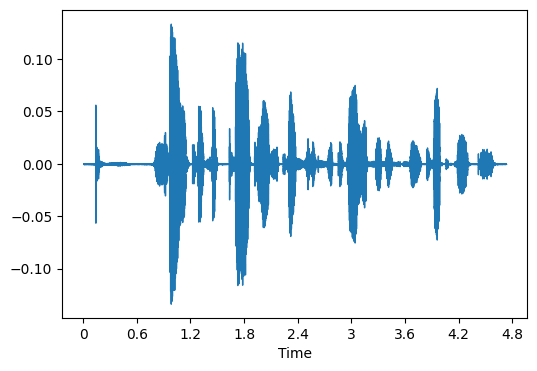

In [334]:
%matplotlib inline
from librosa.display import waveshow
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
waveshow(source_audio_array, sr=sample_rate);

In [335]:
# import librosa
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
    
# # train_audio_path = train_csv[train_csv['is_converted_audio']==True]['path_from_data_dir']
# # test_audio_path = test_csv[test_csv['is_converted_audio']==True]['path_from_data_dir']

# def get_X_and_y(audio_path):
#     X_list = []
#     y_list = []
#     for audio_subpath in tqdm(audio_path):
#         audio_path = timit_dir / 'data' / audio_subpath
#         y = audio_subpath.split('/')[2]
#         y_list.append(y)

#         audio_array, sample_rate = librosa.load(audio_path,
#             sr = None) # Set sr to None to get original sampling rate. Otherwise the default is 22050.
#         # print(f'Shape of audio array: {audio_array.shape}')

#         # https://www.analyticsvidhya.com/blog/2022/03/implementing-audio-classification-project-using-deep-learning/
#         mfccs_features = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=40) # n_mfcc=40 => larger values result in more features
#         # print(f'Shape of mfccs features: {mfccs_features.shape}')
#         X = np.mean(mfccs_features.T, axis=0) # Normalize features into the same scale
#         # print(f'Shape of scaled mfccs features: {X.shape}')
#         X_list.append(X)

#     df = pd.DataFrame(X_list)
#     df['label'] = y_list

#     X = df.drop(['label'], axis=1)
#     y = df['label']

#     return X, y, df

# train_X, train_y, train_df = get_X_and_y(train_audio_path)

In [336]:
# print(train_X.shape, train_y.shape)
# train_df

In [337]:
# test_X, test_y, test_df = get_X_and_y(test_audio_path)
# print(test_X.shape, test_y.shape)
# test_df

In [338]:
# set(train_y) & set(test_y)

cannot use test data for evaluating model prediction accuracy since no labels from test data is found in train data.
Thus, train data will be split into train and test data sets for modeling and evaluation of the model.

In [339]:
# train_y.value_counts().unique()

take 9 as train and 1 as test for each speaker ID (i.e., label) from the original train data sets since each speaker provided 10 sets of audio data, as shown above.

In [340]:
# train_size = 0.7
# train_idx = []
# test_idx = []

# from collections import defaultdict
# label_counts = defaultdict(lambda: 0)
# for idx, row in train_df.sort_values('label').iterrows():
#     label = row['label']
    
#     if label in label_counts:
#         label_counts[label] += 1
#     else:
#         label_counts[label] = 1

#     if label_counts[label] <= (10 * train_size):
#         train_idx.append(idx)
#     else:
#         test_idx.append(idx)

# new_train_df = train_df.iloc[train_idx].reset_index(drop=True)
# new_train_X = new_train_df.drop(['label'], axis=1)
# new_train_y = new_train_df['label']

# new_test_df = train_df.iloc[test_idx].reset_index(drop=True)
# new_test_X = new_test_df.drop(['label'], axis=1)
# new_test_y = new_test_df['label']

# input_shape = (new_train_X.shape[1],)
# num_categories = len(set(new_test_y))

In [341]:
# from utils.transform import normalize_scale
# normalized_train_X, normalized_test_X, scaler = normalize_scale(new_train_X, new_test_X, method="standard")

# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# train_y_cat = to_categorical(label_encoder.fit_transform(new_train_y))
# test_y_cat = to_categorical(label_encoder.transform(new_test_y))

The choice of optimizer in Keras for a multiclass classification problem depends on the architecture of your model, the nature of your dataset, and experimentation. Here are some commonly used optimizers that you can consider for multiclass classification:

1. **Adam (Adaptive Moment Estimation):**
   Adam is a popular and versatile optimizer that combines the benefits of both RMSProp and AdaGrad. It adapts the learning rate for each parameter, providing good convergence properties and fast training. It's often a good starting point due to its effectiveness in various scenarios.

   ```python
   optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
   ```
   What is the best learning rate for Adam optimizer?
      between 0.0001 and 0.01
      An optimal learning rate value (default value 0.001) means that the optimizer would update the parameters just right to reach the local minima. Varying learning rate between 0.0001 and 0.01 is considered optimal in most of the cases.

2. **RMSProp (Root Mean Square Propagation):**
   RMSProp adjusts the learning rate for each parameter based on the moving average of squared gradients. It's effective in handling sparse data and dealing with issues like vanishing and exploding gradients.

   ```python
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
   ```

3. **SGD (Stochastic Gradient Descent):**
   While basic, SGD can still be effective with careful tuning of the learning rate and momentum. However, it might require more manual adjustments compared to adaptive optimizers.

   ```python
   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
   ```

4. **Adadelta:**
   Adadelta is another adaptive optimizer that adjusts the learning rate and accumulates past gradients. It's particularly useful when there's no clear initial learning rate choice.

   ```python
   optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
   ```

5. **Nadam:**
   Nadam combines the benefits of Nesterov accelerated gradient (NAG) and Adam. It's similar to Adam but uses NAG for gradient updates. It's often effective in practice.

   ```python
   optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002)
   ```

It's important to note that the performance of optimizers can vary based on the specific problem and dataset. Experiment with multiple optimizers and different learning rates to find the best one for your model. Also, consider adjusting the learning rate during training using learning rate schedulers to achieve better convergence and performance.

In [342]:
# from utils.statistics import f1_score

# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.optimizers import Adam
# from sklearn import metrics

# dropout_rate = 0.75
# learning_rate = 0.008

# model=Sequential()

# # first layer
# model.add(Dense(1024, activation='relu', input_shape=input_shape))
# model.add(Dropout(dropout_rate)) 

# # second layer
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(dropout_rate))

# # final layer
# model.add(Dense(num_categories, activation='softmax'))

# model.compile(
#     optimizer=Adam(lr=learning_rate),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']) # Predicting the correct class is the primary concern in our case, 
#                           # thus use 'accuracy' as the performance metric.

# model.summary()

In [343]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
import pickle
import json
from tensorflow.keras.models import load_model

best_result_path = 'saved_models/audio_classification.json'
best_model_path = 'saved_models/audio_classification.h5'
scaler_path = 'saved_models/scaler.pkl'
label_encoder_path = 'saved_models/label_encoder.pkl'
if os.path.exists(best_result_path):
        print('Load saved model with scaler, label encoder and results from drive.')
        model = load_model(best_model_path)
        scaler = pickle.load(open(scaler_path, 'rb'))
        label_encoder = pickle.load(open(label_encoder_path, 'rb'))
        history = json.load(open(best_result_path, 'r'))

else:
        num_epochs = 100 # 10
        num_batch_size = 64 # 64

        checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=2, save_best_only=True)

        start = datetime.now()

        history = model.fit(
                normalized_train_X,
                train_y_cat,
                batch_size=num_batch_size,
                epochs=num_epochs,
                validation_data=(normalized_test_X, test_y_cat),
                callbacks=[checkpointer],
                verbose=2
                )
        # By default verbose = 1,
        # verbose = 1, which includes both progress bar and one line per epoch
        # verbose = 0, means silent
        # verbose = 2, one line per epoch i.e. epoch no./total no. of epochs

        duration = datetime.now() - start
        print("Training completed in time: ", duration)

        # Convert the tf.keras.callbacks.History object into a dictionary, if not loaded from local drive.
        if not isinstance(history, dict):
                history = {**history.params, 'epoch': history.epoch, **history.history}

Load saved model with scaler, label encoder and results from drive.


In [344]:
# # Evaluate the model
# test_loss, test_acc = model.evaluate(normalized_test_X, test_y_cat)
# print("Test accuracy:", test_acc)

# for k, v in history.items():
#     best_score = None
#     if 'loss' in k:
#         best_score = min(v)
#     elif 'accuracy' in k:
#         best_score = max(v)

#     if best_score != None:
#         print(f'Best {k}: {round(best_score, 4)}')

In [345]:
# plt.figure(figsize=(16,6))

# plt.subplot(1,2,1)
# plt.plot(history['epoch'], history['loss'], history['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.ylim([0, max(plt.ylim())])
# plt.xlabel('Epoch')
# plt.ylabel('Loss - Categorical Crossentropy')

# plt.subplot(1,2,2)
# plt.plot(history['epoch'],
#         history['accuracy'],
#         history['val_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
# plt.ylim([0, 1])
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy');

In [346]:
# Saving the model and other objects

# model.save(best_model_path)
# pickle.dump(scaler, open(scaler_path, 'wb'))
# pickle.dump(label_encoder, open(label_encoder_path, 'wb'))
# json.dump(history, open(best_result_path, 'w'))

Considering we only have 10 audio files for both training and validation, an accuracy score over 85% is pretty good.

Moving on to verifying whether cloned audio files are correctly classified as the original speaker.

In [347]:
# perfect_transcription_models = eval_df[eval_df['Transcription']==source_text].index
X_list = []
for filename in os.listdir(output_folder):
    # if filename.split('_')[0] in perfect_transcription_models:
    if (source_file_id in filename) and (target_file_id in filename):
        wav_path = output_folder / filename
        model_name = filename.split('/')[-1].split('_')[0]

        audio_array, sample_rate = librosa.load(wav_path, sr=None)
        mfccs_features = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=40)
        X = np.mean(mfccs_features.T, axis=0)
        X_list.append(X)
        
df = pd.DataFrame(X_list)
df['label'] = target_speaker_id

X = df.drop(['label'], axis=1)
y = df['label']

In [348]:
normalized_X = scaler.transform(X)
y_cat = to_categorical(label_encoder.transform(y))

In [349]:
y_pred = np.argmax(model.predict(normalized_X), axis=1)

1/1 [==============================] - 0s 261ms/step


In [350]:
predicted_labels = label_encoder.inverse_transform(y_pred)
predicted_labels

array(['MDLC2', 'MMAG0', 'MDLC2', 'MDLC2', 'MMAG0', 'MDLC2', 'MDLC2',
       'MMBS0', 'MEFG0', 'MDLC2', 'MDLC2', 'MDLC2', 'MDLC2', 'MDLC2',
       'MDLC2', 'MDLC2'], dtype=object)

In [351]:
y

0     MRJT0
1     MRJT0
2     MRJT0
3     MRJT0
4     MRJT0
5     MRJT0
6     MRJT0
7     MRJT0
8     MRJT0
9     MRJT0
10    MRJT0
11    MRJT0
12    MRJT0
13    MRJT0
14    MRJT0
15    MRJT0
Name: label, dtype: object

- pick up one or two files for EDA since typically audio files are very heavy. do not pick up more than 5 files at a time, which might not be even possible.

- Can try these to deal with the volume and high dimensionality of audio data:
1) Google Colab
2) Keras Audio data loading
https://keras.io/api/data_loading/audio/#audio_dataset_from_directory-function


- will need a library that converts audio files to machine-readable data, i.e. numbers.
- will need another library that trains a model (e.g. sequence/ deep learning model for time series audio data).